## Plotting Stocks with Python
This script is intended for explorative analysis of stocks.

__Basic Features Required:__

1. Load data continuously from Yahoo Finance
2. Make simple candlestick plots
3. Calculate a large number of indicators
4. Perform backtesting and statistical tests on strategies

I also need it to perform an analysis that allows me to pick stocks and identify buy/sell signals. It must do the following:

__Features Required for Analysis:__

1. Compare stocks in the OMX-C20 to find the most promising one
2. Identify beginning and end of a trend change
  - Use volume changes and momentum indicators to spot strength of change
3. Evaluate results to produce a buy/sell signal

__Functions To Make:__

1. Make data available as a list of dictionaries. Each dictionary contain the information about the stock such as open, close, high, low, date, and various indicators
2. 


In [1]:
#!/usr/bin/python

# Show plots inline and as .svg
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Basic packages
import time
import timeit
import datetime
import math
from pprint import pprint
from operator import itemgetter

# API for getting data
import yahoo_finance
# API for technical indicators. https://github.com/mrjbq7/ta-lib
import talib

# Data structure
import pandas as pd
import numpy as np

# Plotting
import pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
# http://matplotlib.org/api/finance_api.html
from matplotlib.finance import candlestick
import seaborn as sns
sns.set(color_codes=True)

# DEPRECATED:
#import urllib2

matplotlib.rcParams.update({'font.size': 9})

### Extracting Yahoo Data

I start by reading the OMX-C20 index into a list of stocks (20 most traded stocks in Denmark):

In [2]:
# List of stocks
tickers = [
    'CARL-B.CO',
    'CHR.CO',
    'COLO-B.CO',
    'DANSKE.CO',
    'DSV.CO',
    'FLS.CO',
    'GEN.CO',
    'GN.CO',
    'ISS.CO',
    'JYSK.CO',
    'MAERSK-A.CO',
    'MAERSK-B.CO',
    'NDA-DKK.CO',
    'NOVO-B.CO',
    'NZYM-B.CO',
    'PNDORA.CO',
    'TDC.CO',
    'TRYG.CO',
    'WDH.CO',
    'VWS.CO'
    ]

# Currently not working with yahoo-finance package
exchanges = ['^OMXC20']

Having a list of stocks, I need a function to fetch stock data from Yahoo! Finance. Using the yahoo_finance package, I can do this. 

__Note:__ There is a potential bug with correctly fetching present-day data. Volume, price and high/low may not be correct. Moreover, data are likely 15 min delayed

In [3]:
def get_historical_quotes(ticker, start_date, end_date, DF=True):
    '''Get historical stock data. Use DF = True/False 
    to toggle output as either DataFrame or list of 
    dictionaries, respectively'''

    # Identify ticker
    stock = yahoo_finance.Share(ticker)
    # Get historical data
    stock_data = stock.get_historical(start_date, end_date)
    # Sort the data to ensure yesterday is the first entry
    stock_data = sorted(stock_data, key=itemgetter('Date')) 
    # Convert to Pandas DataFrame if DF == True
    # Else, return list of dictionaries sorted by date in descending order
    if DF==True:
        stock_data = pd.DataFrame(stock_data)
        # Force data into a float format
        for column in stock_data:
            if column not in ['Date', 'Symbol']:
                # Apply float() to column
                stock_data[column] = stock_data[column].apply(float)
    return stock_data

def get_present_quotes(ticker, stock_data, DF=True):
    '''
    Update historic stock data with today's information.
    If the date is already present, update the values.
    Use DF = True/False to toggle output as either 
    DataFrame or list of dictionaries, respectively
    '''

    # Identify ticker and refresh stock data
    stock = yahoo_finance.Share(ticker)
    stock.refresh
    # Create today's data
    todays_data = [{
            'Volume': float(stock.get_volume()),
            'Symbol': ticker,
            'High': float(stock.get_days_high()),
            'Low': float(stock.get_days_low()),
            'Date': stock.get_trade_datetime()[0:10],
            'Open': float(stock.get_open()),
            'Close': float(stock.get_price())
            }]

    # Update pandas DataFrame 
    if DF == True:
        # Update to DataFrame
        todays_data = pd.DataFrame(todays_data)
        # Update today's values if they have been added earlier
        if max(stock_data['Date']) == todays_data['Date'][0]:
            stock_data = pd.concat([
                stock_data.loc[stock_data['Date'] != todays_data['Date'][0]],
                todays_data
                ])
        # Append today's values    
        else:
            stock_data = pd.concat([stock_data, todays_data])
        # Reset row numbers so the DF doesn't start with 0,0,1,2,...
        stock_data = stock_data.reset_index(drop=True)
        return stock_data
    
    # Update list of dictionaries
    else:
        if stock_data[0]['Date'] == todays_data[0]['Date']:
            todays_data.extend(stock_data[1:])
        else:
            todays_data.extend(stock_data)
        return todays_data
    
def time_interval(days_ago, end_date=datetime.datetime.today()):
    '''
    Simple function to return start- and end-date, given 
    the most resent date and the number of days ago for the 
    start-date. Assumes end-date is today unless specified.
    Returns date as YYYY-MM-DD
    '''
    
    # Start date (YYYY-MM-DD)
    start_date = (end_date - datetime.timedelta(days_ago)).strftime('%Y-%m-%d')
    # End date (YYYY-MM-DD)
    end_date = end_date.strftime('%Y-%m-%d')
    # Dates returned as tupple
    return (start_date, end_date)

def financial_data(ticker):
    '''
    Extracts financial data for a given stock. 
    Includes:
        - P/E ratio
        - Price/Sales
        - Price/Book
        - Short ratio
        - EBITDA
        - Book value
    '''
    
    stock = yahoo_finance.Share(ticker)
    financials = pd.DataFrame([{
            'PE_ratio': stock.get_price_earnings_ratio(),
            'PriceSales': stock.get_price_sales(),
            'PriceBook': stock.get_price_book(),
            'short_ratio': stock.get_short_ratio(),
            'EBITDA': stock.get_ebitda(),
            'book_value': stock.get_book_value()}], 
            index=[ticker])
    for column in financials:
        try:
            # Apply float() to column
            financials[column] = financials[column].apply(float)
        except:
            continue
    return financials

With this, I can now extract price data from Yahoo from each stock in the OMX-C20 index and store it in a dictionary (keys = stock tickers, values = dataframe with price/volume/etc). In this case, I choose a 5-year interval. Moreover, I can also fetch some key statistics such as the P/E ratio, EBITDA, book value, etc.  

The function ```yahoo_finance.Share()``` may often fail to fetch the data. The script below circumvents that by continuously retrying until the data has been successfully fetched. 

__NOTE:__ I setting ```DF=False``` may now result in errors or incompatibility with downstream functions, as I solely focus on working with dataframes for storing data.

In [5]:
def stock_dict(tickers, update_only=False, historic_only=False, days_lookback=365*5):
    '''Function to download stock data. Fetches daily data for a 5 year period by default'''
    
    # Empty dictionary to be updated
    all_stocks = {}
    
    for ticker in tickers:
        if update_only==False:
            # HISTORICAL QUOTES
            # Counter of attempts to update
            i = 0
            success = None
            # Keep trying until data is successfully fetched
            while success is None:
                try:
                    # Get historical quotes
                    all_stocks[ticker] = get_historical_quotes(
                        ticker, 
                        # Uses a 5 year interval
                        time_interval(days_lookback)[0], 
                        time_interval(days_lookback)[1],
                        True)
                    success = True
                except:
                    # Track iteration number
                    i += 1
                    pass
            if i > 0:
                print 'Historical data for {ticker} failed {i} times'.format(ticker=ticker, i=i)
        
        if historic_only==False:
            # UPDATE WITH TODAY'S QUOTES
            # Counter of attempts to update
            i = 0
            success = None
            # Keep trying until data is successfully fetched
            while success is None:
                try:
                    # Update with todays quotes
                    all_stocks[ticker] = get_present_quotes(
                        ticker, 
                        all_stocks[ticker], 
                        True)
                    # Break loop
                    success = True
                except:
                    # Track iteration number
                    i += 1
                    pass
            if i > 0:
                print 'Present data for {ticker} failed {i} times'.format(ticker=ticker, i=i)

        # Update with percent change relative to the previous trading day
        all_stocks[ticker]['pctChange'] = all_stocks[ticker].Close.pct_change()*100
        # Create columns with year/month/day separately for easy subsetting
        all_stocks[ticker]['year'] = all_stocks[ticker].Date.str[0:4]
        all_stocks[ticker]['month'] = all_stocks[ticker].Date.str[5:7]
        all_stocks[ticker]['day'] = all_stocks[ticker].Date.str[8:10]
        # Create numerical date for plotting with candlestick
        all_stocks[ticker]['numDate'] = mdates.date2num(
            all_stocks[ticker].Date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d')))

        # Get financials
        try:
            financials = pd.concat([financials, financial_data(ticker)])
        except:
            financials = financial_data(ticker)
    return financials, all_stocks

# Run function to get stock data
financials, all_stocks = stock_dict(tickers)

I then output the last few days for each stock for manual inspection. There is a chance the most recent price/volume is wrong and has to be reloaded. If so, I can rerun the code, but setting the ```update_only=True``` (2nd argument). Ideally, I need to make an argument parser so I won't have to track the order in which I give the arguments.

I then move on to a manual inspection of the output. 

In [6]:
for ticker in tickers:
    pprint(all_stocks[ticker].tail(5))

      Adj_Close  Close        Date   High    Low   Open     Symbol  Volume  \
1298      597.5  597.5  2016-06-28  611.0  597.5  608.5  CARL-B.CO  209400   
1299      607.5  607.5  2016-06-29  608.0  595.5  603.0  CARL-B.CO  287700   
1300      634.5  634.5  2016-06-30  637.5  605.5  607.5  CARL-B.CO  516600   
1301      647.0  647.0  2016-07-01  647.0  635.0  635.0  CARL-B.CO  443300   
1302        NaN  646.5  2016-07-04  652.0  642.5  649.0  CARL-B.CO  121651   

      pctChange  year month day  numDate  
1298   0.758853  2016    06  28   736143  
1299   1.673640  2016    06  29   736144  
1300   4.444444  2016    06  30   736145  
1301   1.970055  2016    07  01   736146  
1302  -0.077280  2016    07  04   736149  
      Adj_Close  Close        Date   High    Low   Open  Symbol  Volume  \
1298      420.0  420.0  2016-06-28  421.6  412.4  414.2  CHR.CO  273000   
1299      429.1  429.1  2016-06-29  431.6  422.4  424.2  CHR.CO  203800   
1300      437.9  437.9  2016-06-30  439.1  429.9

Next, I need to practice some plotting. In this case, I provide a basic plot of the percent change in price over time, colored by the sign (blue = positive, red = negative). 

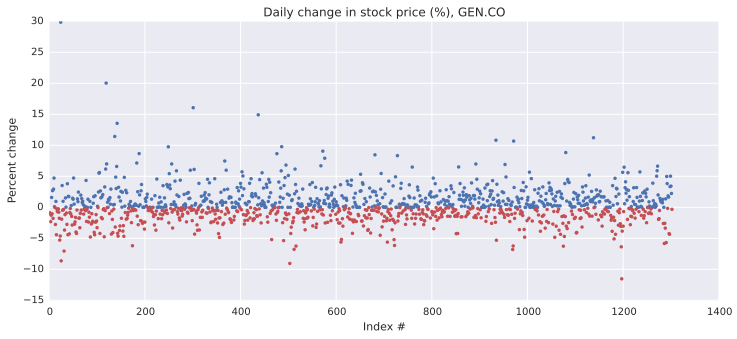

In [7]:
plt.figure(figsize=(12,5))
plt.plot(
    # X-axis. Subset on values >= 0
    all_stocks['GEN.CO'].index[all_stocks['GEN.CO'].pctChange >= 0].values,
    # Y-axis. Subset on values >= 0
    all_stocks['GEN.CO'].pctChange[all_stocks['GEN.CO'].pctChange >= 0].values, 
    # Point type and color
    '.', c='b');
plt.plot(
    # X-axis. Subset on values < 0
    all_stocks['GEN.CO'].index[all_stocks['GEN.CO'].pctChange < 0].values,
    # Y-axis. Subset on values < 0
    all_stocks['GEN.CO'].pctChange[all_stocks['GEN.CO'].pctChange < 0].values,
    # Point type and color
    '.', c='r');
plt.title('Daily change in stock price (%), {stock}'.format(stock='GEN.CO'));
plt.xlabel('Index #');
plt.ylabel('Percent change');

Using the [seaborn package](https://stanford.edu/~mwaskom/software/seaborn/index.html), I can create density plots for the distribution of percent changes over the years. 

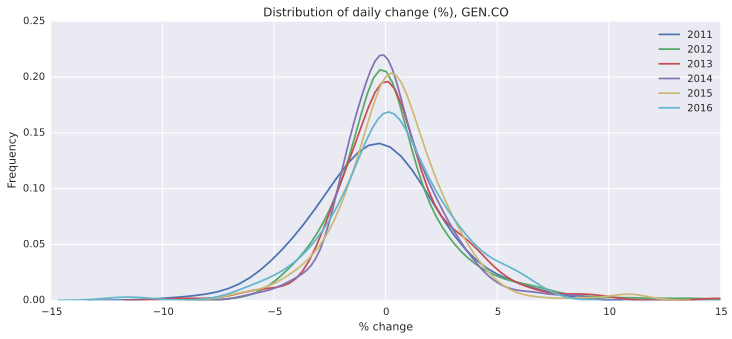

In [8]:
plt.figure(figsize=(12,5))
for year in all_stocks['GEN.CO'].year.unique():
    sns.distplot(
        all_stocks['GEN.CO'].pctChange[all_stocks['GEN.CO'].year == year].dropna().values, 
        hist=False, label=year)
plt.xlim(-15,15)
plt.xlabel('% change');
plt.ylabel('Frequency');
plt.title('Distribution of daily change (%), {stock}'.format(stock='GEN.CO'));
plt.legend();

Below, I show an example on how to create a candlestick plot. Using the candlestick requires data to be in numerical format. 

In this case, I have chosen not to make it a function, as I only use it to illustrate an example on how to use the candlestick plot. However, as I add more subplots, I need to make it into a function so I won't have to repeat the subsetting I do for the dataframe. 

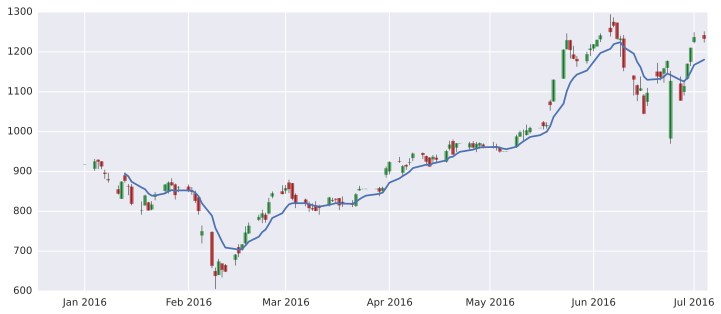

In [21]:

fig, ax = plt.subplots(figsize=(12,5))
# Create candlestick
candlestick(ax, zip(
        # Convert dates to numerical format. Required for candlestick function
        mdates.date2num(
            all_stocks['GEN.CO'].Date[all_stocks['GEN.CO'].year == '2016'].apply(
                # Lambda function to convert string to datetime object that can be converted to numerical
                lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))),
        all_stocks['GEN.CO'].Open[all_stocks['GEN.CO'].year == '2016'],
        all_stocks['GEN.CO'].Close[all_stocks['GEN.CO'].year == '2016'],
        all_stocks['GEN.CO'].High[all_stocks['GEN.CO'].year == '2016'],
        all_stocks['GEN.CO'].Low[all_stocks['GEN.CO'].year == '2016']),
        width=1,
        colorup='g')
# Add 9-day moving average to plot
plt.plot(zip(
        # Convert dates to numerical format. Required for candlestick function
        mdates.date2num(
            all_stocks['GEN.CO'].Date[all_stocks['GEN.CO'].year == '2016'].apply(
                # Lambda function to convert string to datetime object that can be converted to numerical
                lambda x:datetime.datetime.strptime(x, '%Y-%m-%d')))),
        talib.EMA(all_stocks['GEN.CO'].Close[all_stocks['GEN.CO'].year == '2016'].values, timeperiod=9))

# Change from numeric date to meaningful date 
ax.xaxis_date()
plt.show()

I may also want to have a look at the financials; especially the PE-ratio may be interesting, as it relates the earnings to the price. In its most simple form, it points towards underpriced stocks

In [23]:
financials.sort_values('PE_ratio')

,EBITDA,PE_ratio,PriceBook,PriceSales,book_value,short_ratio
JYSK.CO,0,9.77,0.81,2.72,316.14,0
DANSKE.CO,0,13.59,1.09,3.65,161.14,0
TRYG.CO,2.30B,18.41,3.81,2.06,32.26,0
ISS.CO,5.04B,20.06,3.29,0.59,78.07,0
PNDORA.CO,6.69B,22.25,19.69,5.82,45.88,0
GN.CO,1.59B,23.03,3.50,2.14,35.32,0
WDH.CO,2.15B,24.53,5.39,3.28,24.31,0
DSV.CO,3.46B,26.62,4.59,0.98,62.08,0
NOVO-B.CO,50.27B,27.29,24.81,8.41,14.65,0
NZYM-B.CO,4.94B,34.94,9.22,6.98,35.13,0



### On-going and unfinished code:
---

With this framework, I need a way to screen stocks in order to identify those that shows promise for buy/sell signals. An Indicater(-1) indicates the value of the indicator for the previous day. I will include the following signals:

_Momentum Indicators:_

1. Stochastic D-line > 30 & D-line(-1) < 30 = BUY
2. Stochastic D-line < 60 & D-line(-1) > 60 = SELL
3. RSI > 30 & RSI(-1) < 30 = BUY
4. RSI < 70 & RSI(-1) > 70 = SELL

_Volume Indicators:_

1. V-ROC spike = Trend reversal (BUY/SELL)

_Other theories:_

1. A buy and hold strategy may be more efficient. Use moving average and percent changes to identify winning stocks. The theory will be, that it is better to hold a winning stock than one that is loosing. 
    - Use indicators to evaluate when to switch the stock
    - Past performance does not predict future performance. I need to be flexible and switch to faster growing stocks if the momentum declines


Next, I can start making functions to calculate various technical indicators. [This post](https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code) provides a good starting point and allows me to use a dataframe structure.

In [ ]:
#Moving Average  
def MA(df, n):  
    MA = pd.Series(pd.rolling_mean(df['Close'], n), name = 'MA_' + str(n))  
    df = df.join(MA)  
    return df

#Exponential Moving Average  
def EMA(df, n):  
    EMA = pd.Series(pd.ewma(df['Close'], span = n, min_periods = n - 1), name = 'EMA_' + str(n))  
    df = df.join(EMA)  
    return df

#Momentum  
def MOM(df, n):  
    M = pd.Series(df['Close'].diff(n), name = 'Momentum_' + str(n))  
    df = df.join(M)  
    return df

#Rate of Change  
def ROC(df, n):  
    M = df['Close'].diff(n - 1)  
    N = df['Close'].shift(n - 1)  
    ROC = pd.Series(M / N, name = 'ROC_' + str(n))  
    df = df.join(ROC)  
    return df

#Average True Range  
def ATR(df, n):  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(pd.ewma(TR_s, span = n, min_periods = n), name = 'ATR_' + str(n))  
    df = df.join(ATR)  
    return df

#Bollinger Bands  
def BBANDS(df, n):  
    MA = pd.Series(pd.rolling_mean(df['Close'], n))  
    MSD = pd.Series(pd.rolling_std(df['Close'], n))  
    b1 = 4 * MSD / MA  
    B1 = pd.Series(b1, name = 'BollingerB_' + str(n))  
    df = df.join(B1)  
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)  
    B2 = pd.Series(b2, name = 'Bollinger%b_' + str(n))  
    df = df.join(B2)  
    return df

#Pivot Points, Supports and Resistances  
def PPSR(df):  
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)  
    R1 = pd.Series(2 * PP - df['Low'])  
    S1 = pd.Series(2 * PP - df['High'])  
    R2 = pd.Series(PP + df['High'] - df['Low'])  
    S2 = pd.Series(PP - df['High'] + df['Low'])  
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))  
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))  
    psr = {'PP':PP, 'R1':R1, 'S1':S1, 'R2':R2, 'S2':S2, 'R3':R3, 'S3':S3}  
    PSR = pd.DataFrame(psr)  
    df = df.join(PSR)  
    return df

#Stochastic oscillator %K  
def STOK(df):  
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name = 'SO%k')  
    df = df.join(SOk)  
    return df

#Stochastic oscillator %D  
def STO(df, n):  
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name = 'SO%k')  
    SOd = pd.Series(pd.ewma(SOk, span = n, min_periods = n - 1), name = 'SO%d_' + str(n))  
    df = df.join(SOd)  
    return df

#Trix  
def TRIX(df, n):  
    EX1 = pd.ewma(df['Close'], span = n, min_periods = n - 1)  
    EX2 = pd.ewma(EX1, span = n, min_periods = n - 1)  
    EX3 = pd.ewma(EX2, span = n, min_periods = n - 1)  
    i = 0  
    ROC_l = [0]  
    while i + 1 <= df.index[-1]:  
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]  
        ROC_l.append(ROC)  
        i = i + 1  
    Trix = pd.Series(ROC_l, name = 'Trix_' + str(n))  
    df = df.join(Trix)  
    return df

#Average Directional Movement Index  
def ADX(df, n, n_ADX):  
    i = 0  
    UpI = []  
    DoI = []  
    while i + 1 <= df.index[-1]:  
        UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(pd.ewma(TR_s, span = n, min_periods = n))  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(pd.ewma(UpI, span = n, min_periods = n - 1) / ATR)  
    NegDI = pd.Series(pd.ewma(DoI, span = n, min_periods = n - 1) / ATR)  
    ADX = pd.Series(pd.ewma(abs(PosDI - NegDI) / (PosDI + NegDI), span = n_ADX, min_periods = n_ADX - 1), name = 'ADX_' + str(n) + '_' + str(n_ADX))  
    df = df.join(ADX)  
    return df

#MACD, MACD Signal and MACD difference  
def MACD(df, n_fast, n_slow):  
    EMAfast = pd.Series(pd.ewma(df['Close'], span = n_fast, min_periods = n_slow - 1))  
    EMAslow = pd.Series(pd.ewma(df['Close'], span = n_slow, min_periods = n_slow - 1))  
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(pd.ewma(MACD, span = 9, min_periods = 8), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    df = df.join(MACD)  
    df = df.join(MACDsign)  
    df = df.join(MACDdiff)  
    return df

#Mass Index  
def MassI(df):  
    Range = df['High'] - df['Low']  
    EX1 = pd.ewma(Range, span = 9, min_periods = 8)  
    EX2 = pd.ewma(EX1, span = 9, min_periods = 8)  
    Mass = EX1 / EX2  
    MassI = pd.Series(pd.rolling_sum(Mass, 25), name = 'Mass Index')  
    df = df.join(MassI)  
    return df

#Vortex Indicator: http://www.vortexindicator.com/VFX_VORTEX.PDF  
def Vortex(df, n):  
    i = 0  
    TR = [0]  
    while i < df.index[-1]:  
        Range = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR.append(Range)  
        i = i + 1  
    i = 0  
    VM = [0]  
    while i < df.index[-1]:  
        Range = abs(df.get_value(i + 1, 'High') - df.get_value(i, 'Low')) - abs(df.get_value(i + 1, 'Low') - df.get_value(i, 'High'))  
        VM.append(Range)  
        i = i + 1  
    VI = pd.Series(pd.rolling_sum(pd.Series(VM), n) / pd.rolling_sum(pd.Series(TR), n), name = 'Vortex_' + str(n))  
    df = df.join(VI)  
    return df





#KST Oscillator  
def KST(df, r1, r2, r3, r4, n1, n2, n3, n4):  
    M = df['Close'].diff(r1 - 1)  
    N = df['Close'].shift(r1 - 1)  
    ROC1 = M / N  
    M = df['Close'].diff(r2 - 1)  
    N = df['Close'].shift(r2 - 1)  
    ROC2 = M / N  
    M = df['Close'].diff(r3 - 1)  
    N = df['Close'].shift(r3 - 1)  
    ROC3 = M / N  
    M = df['Close'].diff(r4 - 1)  
    N = df['Close'].shift(r4 - 1)  
    ROC4 = M / N  
    KST = pd.Series(pd.rolling_sum(ROC1, n1) + pd.rolling_sum(ROC2, n2) * 2 + pd.rolling_sum(ROC3, n3) * 3 + pd.rolling_sum(ROC4, n4) * 4, name = 'KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(n2) + '_' + str(n3) + '_' + str(n4))  
    df = df.join(KST)  
    return df

#Relative Strength Index  
def RSI(df, n):  
    i = 0  
    UpI = [0]  
    DoI = [0]  
    while i + 1 <= df.index[-1]:  
        UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(pd.ewma(UpI, span = n, min_periods = n - 1))  
    NegDI = pd.Series(pd.ewma(DoI, span = n, min_periods = n - 1))  
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))  
    df = df.join(RSI)  
    return df

#True Strength Index  
def TSI(df, r, s):  
    M = pd.Series(df['Close'].diff(1))  
    aM = abs(M)  
    EMA1 = pd.Series(pd.ewma(M, span = r, min_periods = r - 1))  
    aEMA1 = pd.Series(pd.ewma(aM, span = r, min_periods = r - 1))  
    EMA2 = pd.Series(pd.ewma(EMA1, span = s, min_periods = s - 1))  
    aEMA2 = pd.Series(pd.ewma(aEMA1, span = s, min_periods = s - 1))  
    TSI = pd.Series(EMA2 / aEMA2, name = 'TSI_' + str(r) + '_' + str(s))  
    df = df.join(TSI)  
    return df

#Accumulation/Distribution  
def ACCDIST(df, n):  
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']  
    M = ad.diff(n - 1)  
    N = ad.shift(n - 1)  
    ROC = M / N  
    AD = pd.Series(ROC, name = 'Acc/Dist_ROC_' + str(n))  
    df = df.join(AD)  
    return df

#Chaikin Oscillator  
def Chaikin(df):  
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']  
    Chaikin = pd.Series(pd.ewma(ad, span = 3, min_periods = 2) - pd.ewma(ad, span = 10, min_periods = 9), name = 'Chaikin')  
    df = df.join(Chaikin)  
    return df

#Money Flow Index and Ratio  
def MFI(df, n):  
    PP = (df['High'] + df['Low'] + df['Close']) / 3  
    i = 0  
    PosMF = [0]  
    while i < df.index[-1]:  
        if PP[i + 1] > PP[i]:  
            PosMF.append(PP[i + 1] * df.get_value(i + 1, 'Volume'))  
        else:  
            PosMF.append(0)  
        i = i + 1  
    PosMF = pd.Series(PosMF)  
    TotMF = PP * df['Volume']  
    MFR = pd.Series(PosMF / TotMF)  
    MFI = pd.Series(pd.rolling_mean(MFR, n), name = 'MFI_' + str(n))  
    df = df.join(MFI)  
    return df

#On-balance Volume  
def OBV(df, n):  
    i = 0  
    OBV = [0]  
    while i < df.index[-1]:  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') > 0:  
            OBV.append(df.get_value(i + 1, 'Volume'))  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') == 0:  
            OBV.append(0)  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') < 0:  
            OBV.append(-df.get_value(i + 1, 'Volume'))  
        i = i + 1  
    OBV = pd.Series(OBV)  
    OBV_ma = pd.Series(pd.rolling_mean(OBV, n), name = 'OBV_' + str(n))  
    df = df.join(OBV_ma)  
    return df

#Force Index  
def FORCE(df, n):  
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name = 'Force_' + str(n))  
    df = df.join(F)  
    return df

#Ease of Movement  
def EOM(df, n):  
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])  
    Eom_ma = pd.Series(pd.rolling_mean(EoM, n), name = 'EoM_' + str(n))  
    df = df.join(Eom_ma)  
    return df

#Commodity Channel Index  
def CCI(df, n):  
    PP = (df['High'] + df['Low'] + df['Close']) / 3  
    CCI = pd.Series((PP - pd.rolling_mean(PP, n)) / pd.rolling_std(PP, n), name = 'CCI_' + str(n))  
    df = df.join(CCI)  
    return df

#Coppock Curve  
def COPP(df, n):  
    M = df['Close'].diff(int(n * 11 / 10) - 1)  
    N = df['Close'].shift(int(n * 11 / 10) - 1)  
    ROC1 = M / N  
    M = df['Close'].diff(int(n * 14 / 10) - 1)  
    N = df['Close'].shift(int(n * 14 / 10) - 1)  
    ROC2 = M / N  
    Copp = pd.Series(pd.ewma(ROC1 + ROC2, span = n, min_periods = n), name = 'Copp_' + str(n))  
    df = df.join(Copp)  
    return df

#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(pd.rolling_mean((df['High'] + df['Low'] + df['Close']) / 3, n), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(pd.rolling_mean((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3, n), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(pd.rolling_mean((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3, n), name = 'KelChD_' + str(n))  
    df = df.join(KelChM)  
    df = df.join(KelChU)  
    df = df.join(KelChD)  
    return df

#Ultimate Oscillator  
def ULTOSC(df):  
    i = 0  
    TR_l = [0]  
    BP_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        BP = df.get_value(i + 1, 'Close') - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        BP_l.append(BP)  
        i = i + 1  
    UltO = pd.Series((4 * pd.rolling_sum(pd.Series(BP_l), 7) / pd.rolling_sum(pd.Series(TR_l), 7)) + (2 * pd.rolling_sum(pd.Series(BP_l), 14) / pd.rolling_sum(pd.Series(TR_l), 14)) + (pd.rolling_sum(pd.Series(BP_l), 28) / pd.rolling_sum(pd.Series(TR_l), 28)), name = 'Ultimate_Osc')  
    df = df.join(UltO)  
    return df


#Donchian Channel  
def DONCH(df, n):  
    i = 0  
    DC_l = []  
    while i < n - 1:  
        DC_l.append(0)  
        i = i + 1  
    i = 0  
    while i + n - 1 < df.index[-1]:  
        DC = max(df['High'].ix[i:i + n - 1]) - min(df['Low'].ix[i:i + n - 1])  
        DC_l.append(DC)  
        i = i + 1  
    DonCh = pd.Series(DC_l, name = 'Donchian_' + str(n))  
    DonCh = DonCh.shift(n - 1)  
    df = df.join(DonCh)  
    return df

#Standard Deviation  
def STDDEV(df, n):  
    df = df.join(pd.Series(pd.rolling_std(df['Close'], n), name = 'STD_' + str(n)))  
    return df

The next two chunks of code are taken from [here](https://pythonprogramming.net/advanced-matplotlib-graphing-charting-tutorial/). They do not use my data, but rather fetch it themselves. Overall, the code needs to be edited to fit my framework.

In [ ]:
#all_stocks['GEN.CO']['ema9'] = pd.DataFrame(talib.EMA(all_stocks['GEN.CO'].Close.values, timeperiod=9))
pprint(talib.get_function_groups())


In [ ]:
def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

def movingaverage(values,window):
    weigths = np.repeat(1.0, window)/window
    smas = np.convolve(values, weigths, 'valid')
    return smas # as a numpy array

def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a


def computeMACD(x, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow


Finlly, I have a function to plot the data:

In [ ]:
def graphData(stock,MA1,MA2):
    '''
        Use this to dynamically pull a stock:
    '''
    try:
        print 'Currently Pulling',stock
        print str(datetime.datetime.fromtimestamp(int(time.time())).strftime('%Y-%m-%d %H:%M:%S'))
        urlToVisit = 'http://chartapi.finance.yahoo.com/instrument/1.0/'+stock+'/chartdata;type=quote;range=10y/csv'
        stockFile =[]
        try:
            sourceCode = urllib2.urlopen(urlToVisit).read()
            splitSource = sourceCode.split('\n')
            for eachLine in splitSource:
                splitLine = eachLine.split(',')
                if len(splitLine)==6:
                    if 'values' not in eachLine:
                        stockFile.append(eachLine)
        except Exception, e:
            print str(e), 'failed to organize pulled data.'
    except Exception,e:
        print str(e), 'failed to pull pricing data'
    try:   
        date, closep, highp, lowp, openp, volume = np.loadtxt(stockFile,delimiter=',', unpack=True,
                                                              converters={ 0: mdates.strpdate2num('%Y%m%d')})
        x = 0
        y = len(date)
        newAr = []
        while x < y:
            appendLine = date[x],openp[x],closep[x],highp[x],lowp[x],volume[x]
            newAr.append(appendLine)
            x+=1
            
        Av1 = movingaverage(closep, MA1)
        Av2 = movingaverage(closep, MA2)

        SP = len(date[MA2-1:])
            
        fig = plt.figure(facecolor='#07000d')

        ax1 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4, axisbg='#07000d')
        candlestick(ax1, newAr[-SP:], width=.6, colorup='#53c156', colordown='#ff1717')

        Label1 = str(MA1)+' SMA'
        Label2 = str(MA2)+' SMA'

        ax1.plot(date[-SP:],Av1[-SP:],'#e1edf9',label=Label1, linewidth=1.5)
        ax1.plot(date[-SP:],Av2[-SP:],'#4ee6fd',label=Label2, linewidth=1.5)
        
        ax1.grid(True, color='w')
        ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.yaxis.label.set_color("w")
        ax1.spines['bottom'].set_color("#5998ff")
        ax1.spines['top'].set_color("#5998ff")
        ax1.spines['left'].set_color("#5998ff")
        ax1.spines['right'].set_color("#5998ff")
        ax1.tick_params(axis='y', colors='w')
        plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
        ax1.tick_params(axis='x', colors='w')
        plt.ylabel('Stock price and Volume')

        maLeg = plt.legend(loc=9, ncol=2, prop={'size':7},
                   fancybox=True, borderaxespad=0.)
        maLeg.get_frame().set_alpha(0.4)
        textEd = pylab.gca().get_legend().get_texts()
        pylab.setp(textEd[0:5], color = 'w')

        volumeMin = 0
        
        ax0 = plt.subplot2grid((6,4), (0,0), sharex=ax1, rowspan=1, colspan=4, axisbg='#07000d')
        rsi = rsiFunc(closep)
        rsiCol = '#c1f9f7'
        posCol = '#386d13'
        negCol = '#8f2020'
        
        ax0.plot(date[-SP:], rsi[-SP:], rsiCol, linewidth=1.5)
        ax0.axhline(70, color=negCol)
        ax0.axhline(30, color=posCol)
        ax0.fill_between(date[-SP:], rsi[-SP:], 70, where=(rsi[-SP:]>=70), facecolor=negCol, edgecolor=negCol, alpha=0.5)
        ax0.fill_between(date[-SP:], rsi[-SP:], 30, where=(rsi[-SP:]<=30), facecolor=posCol, edgecolor=posCol, alpha=0.5)
        ax0.set_yticks([30,70])
        ax0.yaxis.label.set_color("w")
        ax0.spines['bottom'].set_color("#5998ff")
        ax0.spines['top'].set_color("#5998ff")
        ax0.spines['left'].set_color("#5998ff")
        ax0.spines['right'].set_color("#5998ff")
        ax0.tick_params(axis='y', colors='w')
        ax0.tick_params(axis='x', colors='w')
        plt.ylabel('RSI')

        ax1v = ax1.twinx()
        ax1v.fill_between(date[-SP:],volumeMin, volume[-SP:], facecolor='#00ffe8', alpha=.4)
        ax1v.axes.yaxis.set_ticklabels([])
        ax1v.grid(False)
        ###Edit this to 3, so it's a bit larger
        ax1v.set_ylim(0, 3*volume.max())
        ax1v.spines['bottom'].set_color("#5998ff")
        ax1v.spines['top'].set_color("#5998ff")
        ax1v.spines['left'].set_color("#5998ff")
        ax1v.spines['right'].set_color("#5998ff")
        ax1v.tick_params(axis='x', colors='w')
        ax1v.tick_params(axis='y', colors='w')
        ax2 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4, axisbg='#07000d')
        fillcolor = '#00ffe8'
        nslow = 26
        nfast = 12
        nema = 9
        emaslow, emafast, macd = computeMACD(closep)
        ema9 = ExpMovingAverage(macd, nema)
        ax2.plot(date[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
        ax2.plot(date[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
        ax2.fill_between(date[-SP:], macd[-SP:]-ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)

        plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
        ax2.spines['bottom'].set_color("#5998ff")
        ax2.spines['top'].set_color("#5998ff")
        ax2.spines['left'].set_color("#5998ff")
        ax2.spines['right'].set_color("#5998ff")
        ax2.tick_params(axis='x', colors='w')
        ax2.tick_params(axis='y', colors='w')
        plt.ylabel('MACD', color='w')
        ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
        for label in ax2.xaxis.get_ticklabels():
            label.set_rotation(45)

        plt.suptitle(stock.upper(),color='w')

        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax1.get_xticklabels(), visible=False)
        
        ax1.annotate('Big news!',(date[510],Av1[510]),
            xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='white', shrink=0.05),
            fontsize=14, color = 'w',
            horizontalalignment='right', verticalalignment='bottom')

        plt.subplots_adjust(left=.09, bottom=.14, right=.94, top=.95, wspace=.20, hspace=0)
        plt.show()
        fig.savefig('example.png',facecolor=fig.get_facecolor())
           
    except Exception,e:
        print 'main loop',str(e)

while True:
    stock = raw_input('Stock to plot: ')
    graphData(stock,10,50)